# Library Imports and Resource Initialization

In [12]:
!pip install bert_score

# === General Utilities ===
import os
import json
import csv
import types
import re
import time
from pathlib import Path
from collections import Counter

# === Data Science & Evaluation ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

# === NLTK ===
import nltk
from nltk.corpus import wordnet as wn
from nltk.translate.meteor_score import meteor_score
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

# === PyTorch ===
import torch
from torch.utils.data import Dataset, DataLoader

# === Transformers & HuggingFace ===
from transformers import (
    BlipProcessor,
    BlipForQuestionAnswering,
    get_scheduler,
    BartTokenizer,
    BartForConditionalGeneration,
)
from bert_score import score as b_score, BERTScorer

# === LoRA / PEFT ===
from peft import LoraConfig, get_peft_model

# === Logging & Progress ===
from rich.console import Console
from rich.progress import track

# === Mixed Precision ===
from contextlib import nullcontext
from torch.cuda.amp import autocast

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


# Path Configuration for Dataset, Model, and Outputs

In [13]:
# Define paths
IMAGE_BASE_DIR = "/kaggle/input/blip-dataset/images/images/small"
VQA_DATA_FILE = "/kaggle/input/blip-dataset/complete_vqa.csv"
INPUT_IMAGES_FILE = "/kaggle/input/blip-dataset/images/images/metadata/images.csv"
OUTPUT_RESULTS_FILE = "/kaggle/working/vqa_results.csv"
MODEL_SAVE_PATH = "/kaggle/working/blip_lora_finetuned"
MODEL_PATH = "/kaggle/input/blip-lora-finetuned/blip_lora_model"

# Dataset Loading and Preparation

In [16]:
# To Load custom dataset into a json structure
def load_vqa_data():
    """Load the VQA dataset from CSV."""
    # Read CSV file
    df = pd.read_csv(VQA_DATA_FILE)

    # Ensure required columns exist
    required_columns = ['image_path', 'question', 'answer']
    if not all(col in df.columns for col in required_columns):
        missing = [col for col in required_columns if col not in df.columns]
        raise ValueError(f"CSV file missing required columns: {missing}")
    
    # Group by image_path 
    vqa_data = []
    for image_path, group in df.groupby('image_path'):
        questions = [
            {"question": row['question'], "answer": str(row['answer'])}
            for _, row in group.iterrows()
        ]
        vqa_data.append({
            "image_path": image_path,
            "questions": questions
        })
    
    return vqa_data
    
console = Console()

vqa_data = load_vqa_data()
train_data, test_data = train_test_split(vqa_data, test_size=0.2, random_state=42)

# Fine-Tuning BLIP-VQA-Base with LoRA on VQA Dataset

In [17]:
# Custom Dataset for VQA
class VQADataset(Dataset):
    def __init__(self, vqa_data, processor, image_base_dir):
        self.processor = processor
        self.image_base_dir = image_base_dir

        # Flatten and index all question items up front
        self.samples = []
        for item in vqa_data:
            image_path = os.path.join(image_base_dir, item["image_path"])
            for qa in item["questions"]:
                self.samples.append({
                    "image_path": image_path,
                    "question": qa["question"],
                    "answer": qa["answer"]
                })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        image_path = sample["image_path"]
        question = sample["question"]
        answer = re.sub(r'[^\w\s]', '', sample["answer"]).strip()

        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found at {image_path}")

        image = Image.open(image_path).convert("RGB")

        # Process inputs (question + image)
        inputs = self.processor(
            images=image,
            text=question,
            return_tensors="pt",
            padding=True
        )

        # Tokenize answer
        answer_tokens = self.processor.tokenizer(
            answer,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=20
        )

        inputs["labels"] = answer_tokens["input_ids"]

        # Optional: Clamp invalid token IDs (should rarely happen)
        vocab_size = self.processor.tokenizer.vocab_size
        if inputs["labels"].max().item() >= vocab_size:
            print(f"Warning: Invalid token ID in labels for answer: {answer}")
            inputs["labels"] = torch.clamp(inputs["labels"], max=vocab_size - 1)

        # Remove batch dimension (1) to make outputs compatible with DataLoader
        return {k: v.squeeze(0) for k, v in inputs.items()}

# Custom collate function to pad tensors
def collate_fn(batch, processor):
    pixel_values = torch.stack([item["pixel_values"].squeeze(0) for item in batch])
    input_ids = [item["input_ids"].squeeze(0) for item in batch]
    attention_mask = [item["attention_mask"].squeeze(0) for item in batch]
    labels = [item["labels"].squeeze(0) for item in batch]
    
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=processor.tokenizer.pad_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence(attention_mask, batch_first=True, padding_value=0)
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=-100)
    
    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

def configure_lora(model):
    lora_config = LoraConfig(
        r=16,
        lora_alpha=16,
        target_modules=["query", "value"],
        lora_dropout=0.05,
        bias="none",
        task_type="QUESTION_ANS"
    )
    model = get_peft_model(model, lora_config)
    
    original_base_forward = model.base_model.forward
    
    def custom_base_forward(self, *args, **kwargs):
        supported_kwargs = {
            k: v for k, v in kwargs.items()
            if k in [
                "pixel_values", "input_ids", "attention_mask", "labels",
                "output_attentions", "output_hidden_states", "return_dict",
                "interpolate_pos_encoding"
            ]
        }
        return original_base_forward(*args, **supported_kwargs)
    
    model.base_model.forward = types.MethodType(custom_base_forward, model.base_model)
    
    model.print_trainable_parameters()
    return model

def fine_tune_with_lora(train_data, epochs=3, batch_size=8, lr=5e-5, use_amp=True, save_path=MODEL_SAVE_PATH):
    # === Setup ===
    console.rule("[bold blue]Initializing BLIP for VQA with LoRA")
    processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
    model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
    model = configure_lora(model)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    train_dataset = VQADataset(train_data, processor, IMAGE_BASE_DIR)
    dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
        collate_fn=lambda batch: collate_fn(batch, processor)
    )
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    total_steps = len(dataloader) * epochs
    lr_scheduler = get_scheduler("linear", optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # === Optional AMP Setup ===
    scaler = torch.cuda.amp.GradScaler() if use_amp else None

    # === Training Loop ===
    model.train()
    for epoch in range(epochs):
        start_time = time.perf_counter()
        total_samples = 0
        
        console.rule(f"[bold green]Epoch {epoch + 1}/{epochs}")
        running_loss = 0

        for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1}", leave=False):
            inputs = {
                "pixel_values": batch["pixel_values"].to(device),
                "input_ids": batch["input_ids"].to(device),
                "attention_mask": batch["attention_mask"].to(device),
                "labels": batch["labels"].to(device),
                "use_cache": True,
            }

            optimizer.zero_grad()

            if use_amp:
                with torch.cuda.amp.autocast():
                    outputs = model(**inputs)
                    loss = outputs.loss
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(**inputs)
                loss = outputs.loss
                loss.backward()
                optimizer.step()

            lr_scheduler.step()
            running_loss += loss.item()

            total_samples += len(batch["pixel_values"])

        avg_loss = running_loss / len(dataloader)
        epoch_duration = time.perf_counter() - start_time
        
        console.print(f"Epoch {epoch + 1}/{epochs} - Average Loss: {avg_loss:.4f}", style="bold yellow")
        console.print(f"Epoch Time: {epoch_duration:.2f}s - Samples Processed: {total_samples}", style="bold blue")

    # === Save Model & Processor ===
    os.makedirs(save_path, exist_ok=True)
    model.save_pretrained(save_path)
    processor.save_pretrained(save_path)
    console.rule("[bold magenta]Training complete. Model saved.")

    return processor, model, device
    

print("Fine-tuning BLIP with LoRA...")
processor, model, device = fine_tune_with_lora(train_data)

print(f"Fine-tuned model saved to {MODEL_SAVE_PATH}")

Fine-tuning BLIP with LoRA...


─────────────────────────────────────── Initializing BLIP for VQA with LoRA ───────────────────────────────────────

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

trainable params: 2,359,296 || all params: 387,031,868 || trainable%: 0.6096


/tmp/ipykernel_98/2590391084.py:132: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


──────────────────────────────────────────────────── Epoch 1/3 ────────────────────────────────────────────────────

Epoch 1:   0%|          | 0/4547 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/ipykernel_98/2590391084.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingf

Epoch 1/3 - Average Loss: 7.9926

Epoch Time: 1281.78s - Samples Processed: 36373

──────────────────────────────────────────────────── Epoch 2/3 ────────────────────────────────────────────────────

Epoch 2:   0%|          | 0/4547 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 2/3 - Average Loss: 7.8479

Epoch Time: 1272.55s - Samples Processed: 36373

──────────────────────────────────────────────────── Epoch 3/3 ────────────────────────────────────────────────────

Epoch 3:   0%|          | 0/4547 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 3/3 - Average Loss: 7.8063

Epoch Time: 1271.44s - Samples Processed: 36373

───────────────────────────────────────── Training complete. Model saved. ─────────────────────────────────────────

Fine-tuned model saved to /kaggle/working/blip_lora_finetuned


# Inference and Evaluation on the VQA Test Set

Output()

/tmp/ipykernel_98/3454810596.py:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use 
`torch.amp.autocast('cuda', args...)` instead.
  with amp_context():

Output()

Running inference with fine-tuned model...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inference complete. Results saved to /kaggle/working/vqa_results.csv.

Evaluating results...

--- BLIP-VQA Evaluation Summary ---

Total samples: 9110

Exact Match         : 0.6709
Token Match         : 0.6709
Wup Score           : 0.8339
F1 Score            : 0.6712
Meteor Score        : 0.3436
Bertscore F1        : 0.9855
Bart Score          : -4.5013


------ Per Question Type ------

Counting (972 samples)
  Exact Match         : 0.5751
  Token Match         : 0.5751
  Wup Score           : 0.9276
  F1 Score            : 0.5751
  Meteor Score        : 0.2876
  Bertscore F1        : 0.9987
  Bart Score          : -4.1789

Color (3191 samples)
  Exact Match         : 0.7505
  Token Match         : 0.7505
  Wup Score           : 0.8782
  F1 Score            : 0.7505
  Meteor Score        : 0.3826
  Bertscore F1        : 0.9870
  Bart Score          : -4.4865

Yes/No (1388 samples)
  Exact Match         : 0.9164
  Token Match         : 0.9164
  Wup Score           : 0.9375
  F1 Score            : 0.9164
  Meteor Score        : 0.4589
  Bertscore F1       

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Saved: metric_distributions.png


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_

Saved: metrics_by_question_type.png
Saved: metric_correlation_heatmap.png
Saved: f1_vs_length.png


/tmp/ipykernel_98/3454810596.py:390: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("question_type")[["exact_match", "f1_score", "bertscore_f1", "wup_score"]].mean()
/tmp/ipykernel_98/3454810596.py:393: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  grouped = grouped.fillna(0)


Saved: error_heatmap.png

Results saved to /kaggle/working/vqa_results.csv


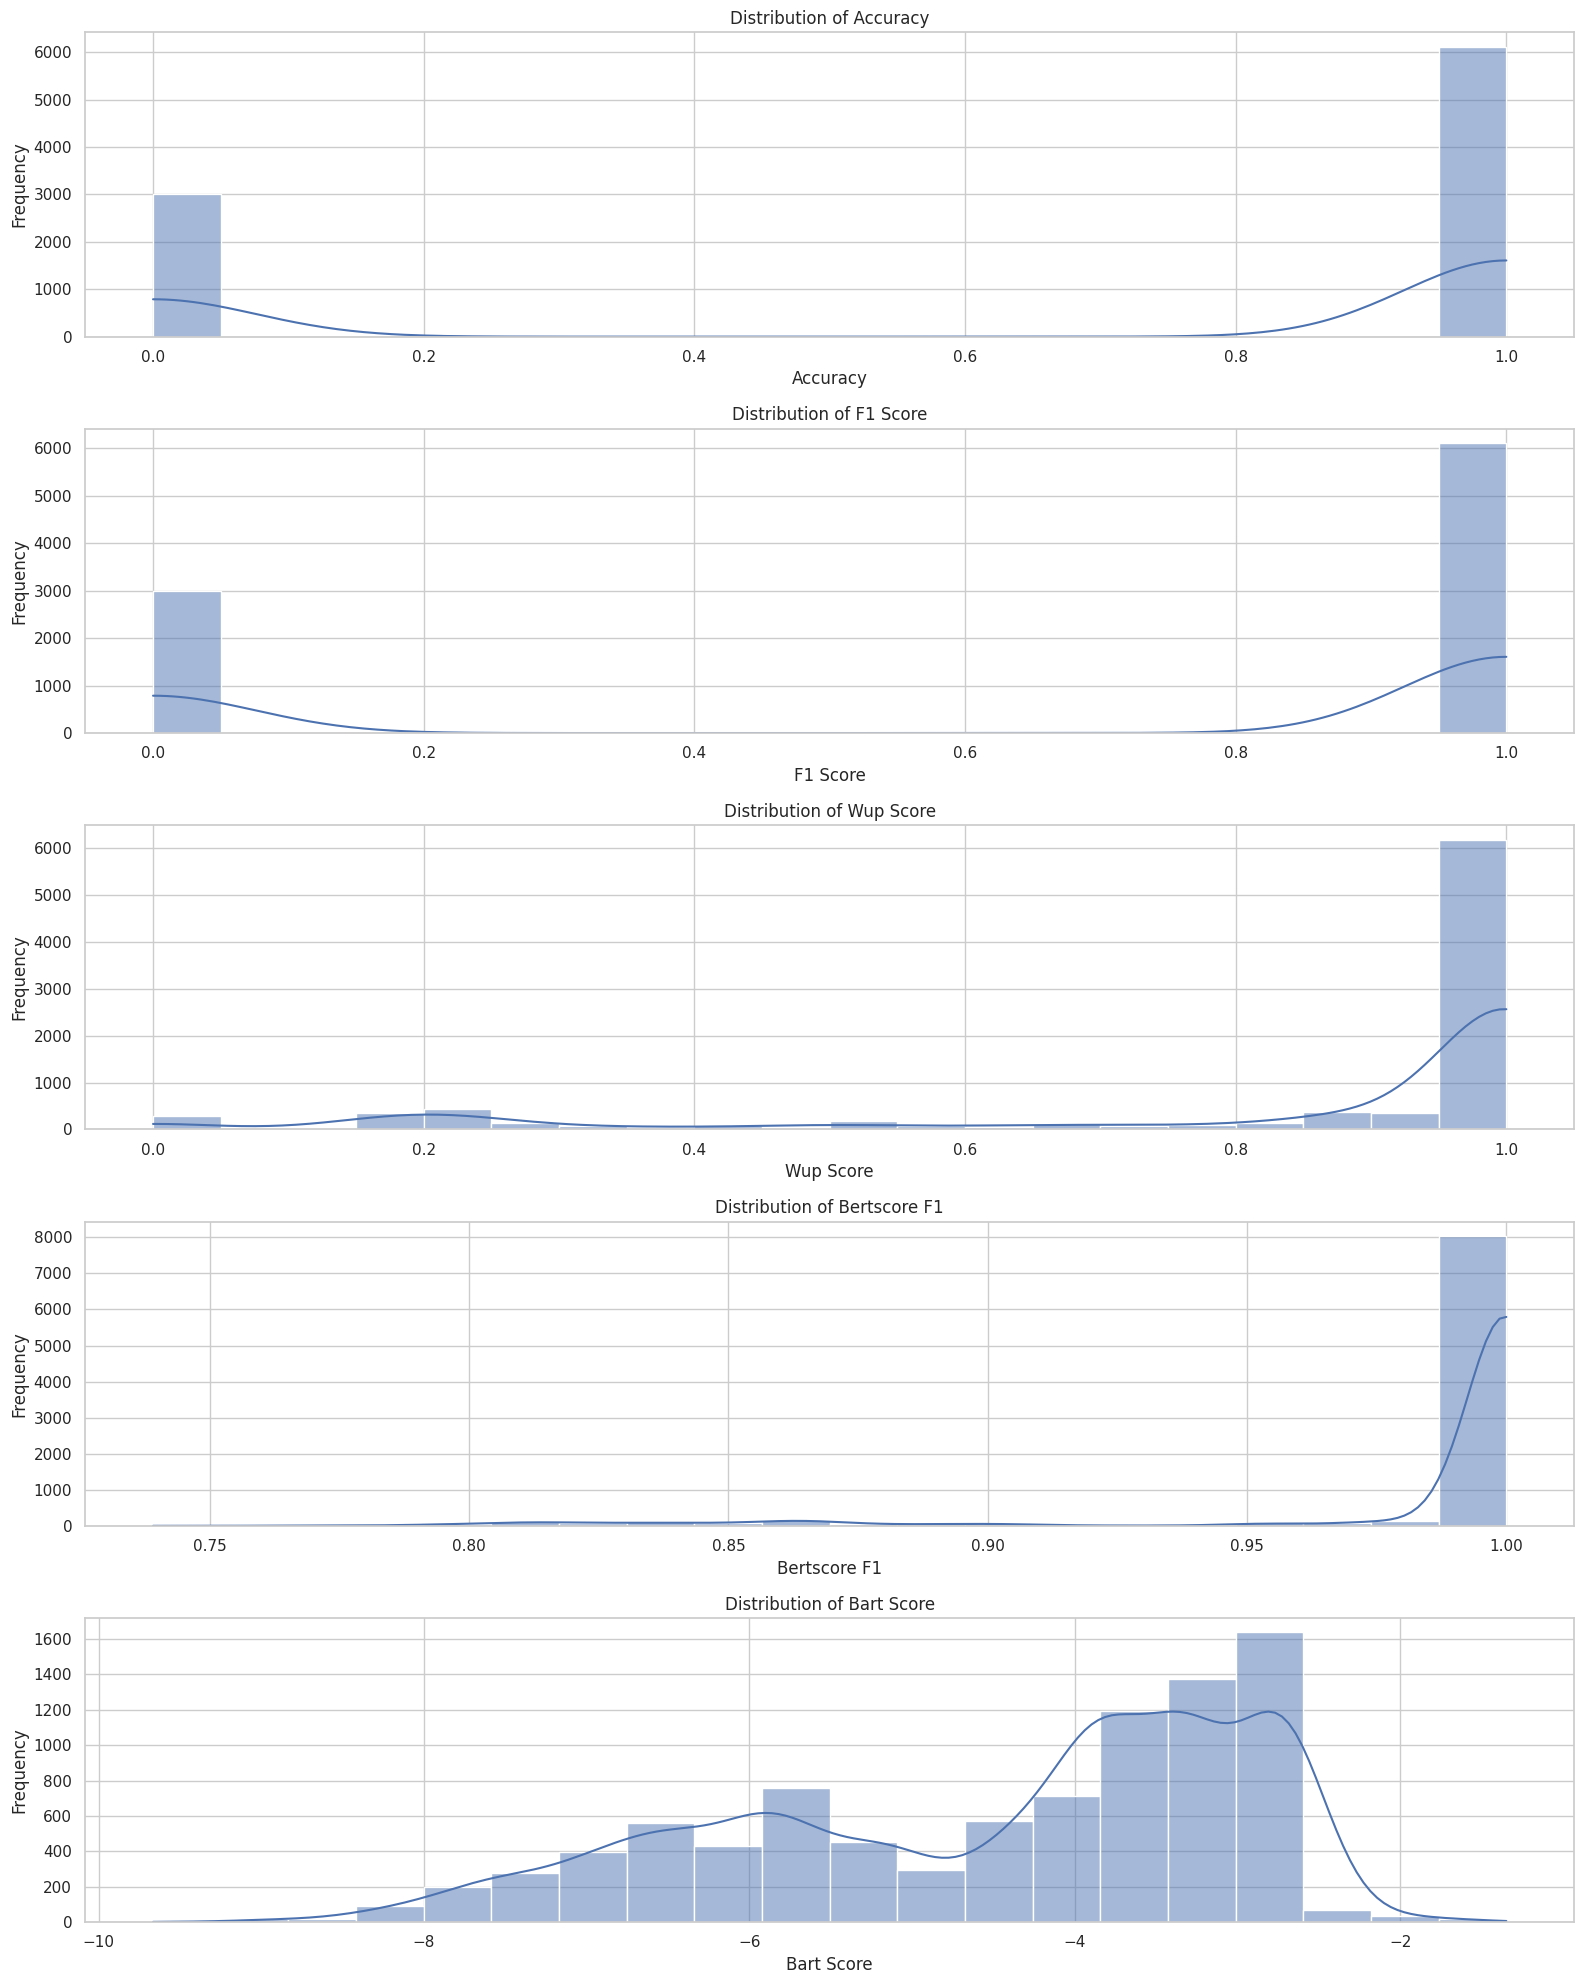

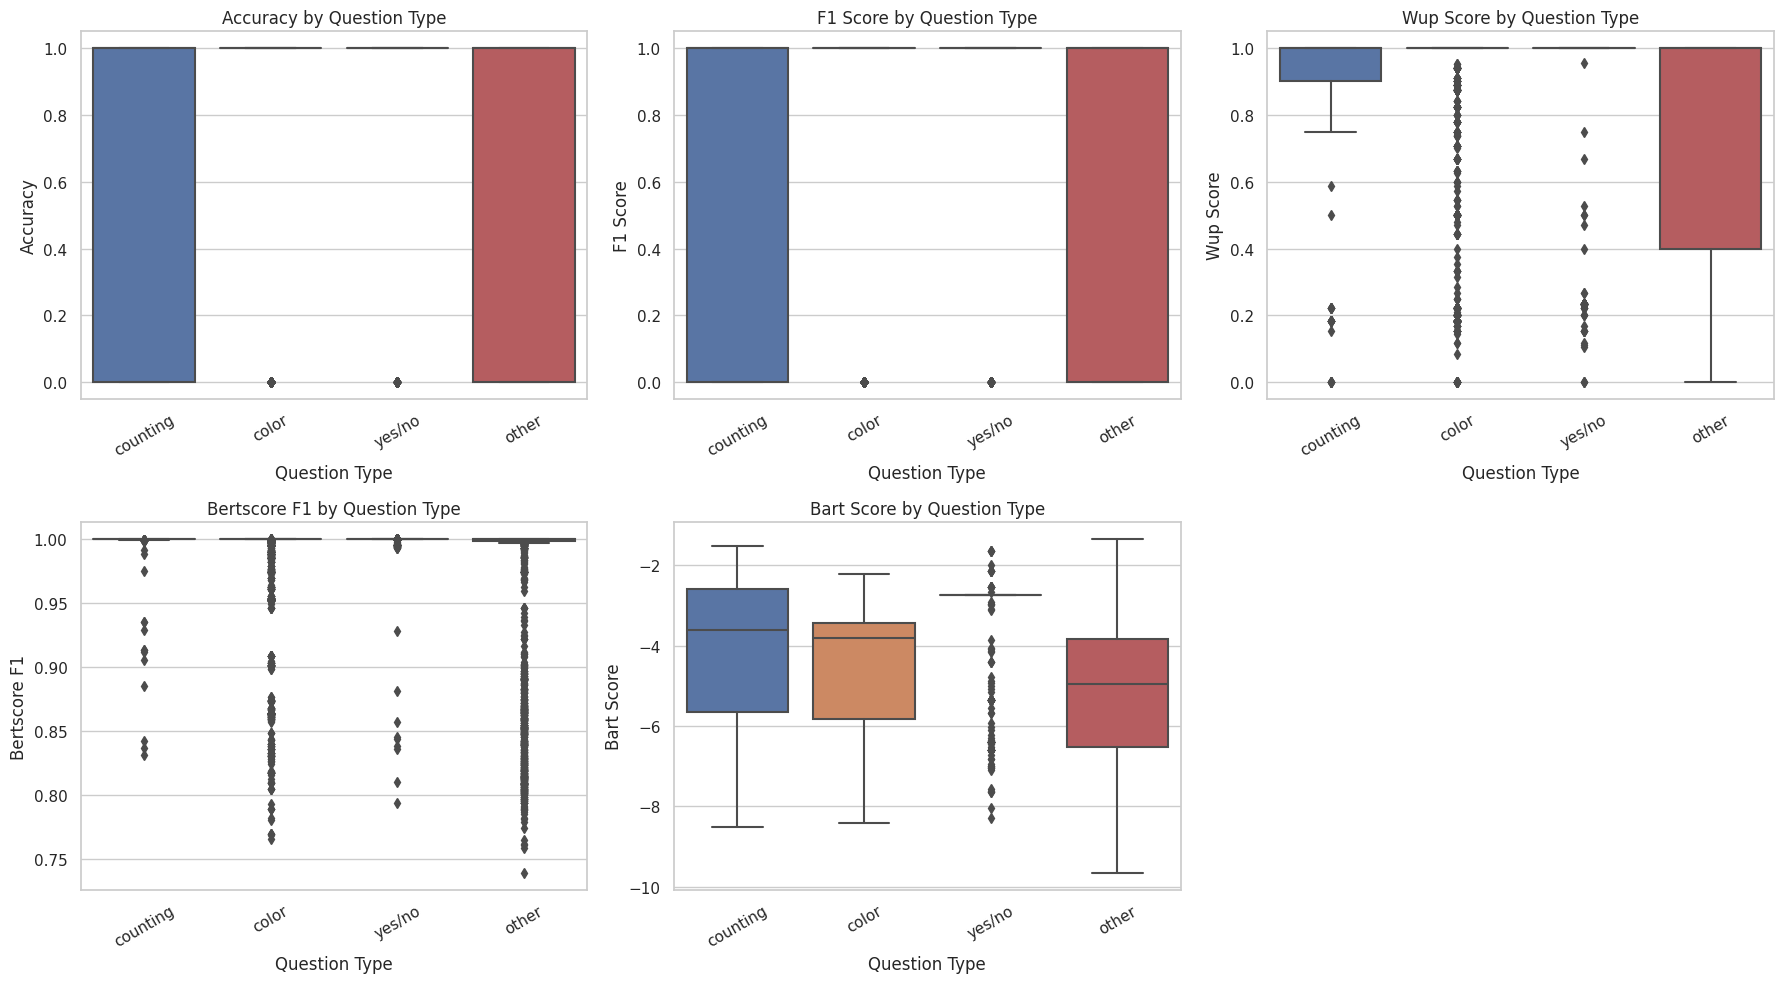

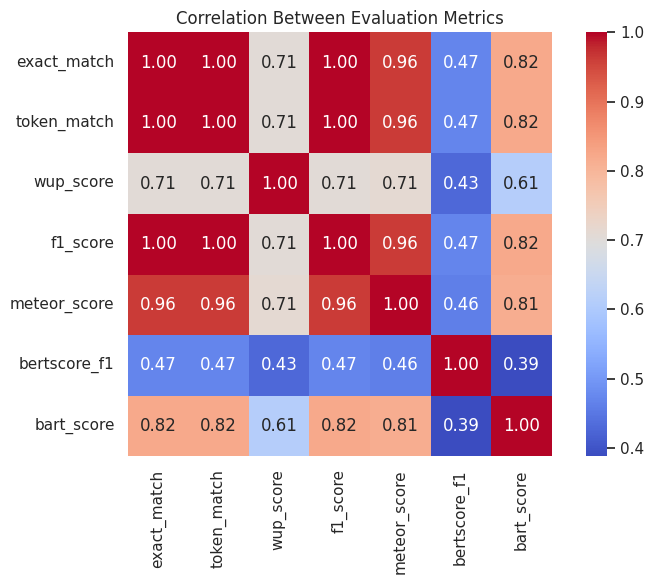

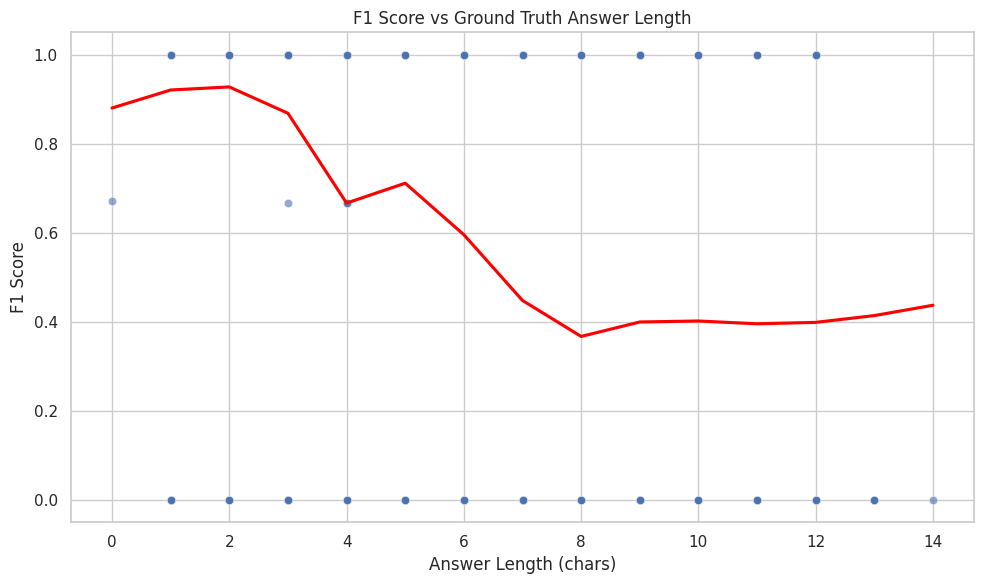

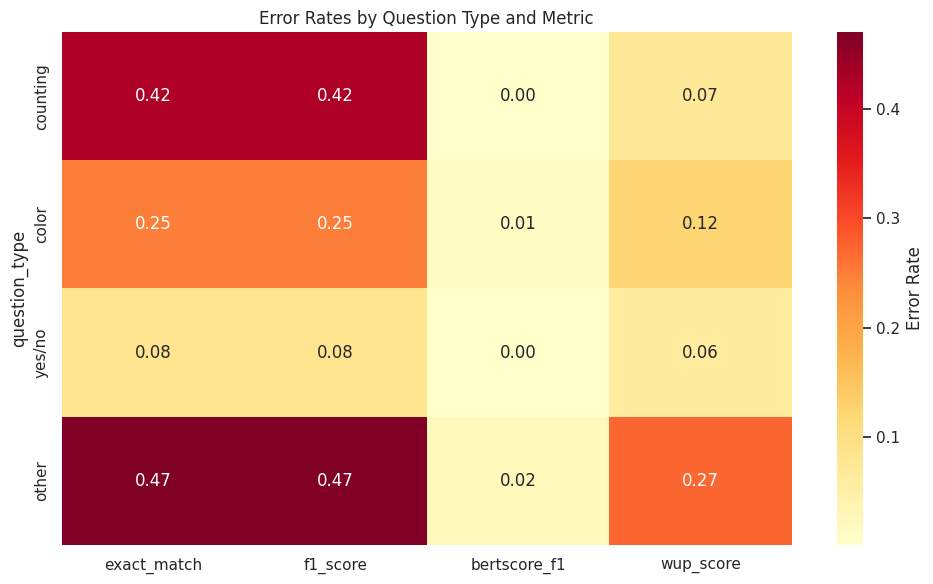

In [15]:
# Initialize BART model for BARTScore
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bart_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")
bart_model.eval().to(device)

def normalize_answer(s):
    """Normalize answer for more accurate comparison."""
    # Define reversed number map (digits to words)
    number_map = {
        '0': 'zero', '1': 'one', '2': 'two', '3': 'three', '4': 'four',
        '5': 'five', '6': 'six', '7': 'seven', '8': 'eight', '9': 'nine', '10': 'ten'
    }
    
    # Convert digits to words
    for digit, word in number_map.items():
        s = re.sub(r'\b' + digit + r'\b', word, s.lower())
    
    # Remove articles
    s = re.sub(r'\b(a|an|the)\b', ' ', s)
    # Remove punctuation and extra whitespace
    s = re.sub(r'[^\w\s]', '', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def exact_match(pred, ref):
    """
    Check if normalized prediction and reference strings match exactly.
    """
    return normalize_answer(pred) == normalize_answer(ref)

def token_match(pred, ref):
    """
    Check if token distributions match (ignores order and punctuation).
    """
    pred_tokens = Counter(normalize_answer(pred).split())
    ref_tokens = Counter(normalize_answer(ref).split())
    return pred_tokens == ref_tokens

def get_wordnet_pos(word):
    """
    Map POS tag to WordNet POS format (default to NOUN).
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    return {"J": wn.ADJ, "N": wn.NOUN, "V": wn.VERB, "R": wn.ADV}.get(tag, wn.NOUN)

def calculate_wup_score(pred, ref):
    """
    Compute average Wu-Palmer similarity between tokens in prediction and reference.
    """
    pred_tokens = normalize_answer(pred).split()
    ref_tokens = normalize_answer(ref).split()

    if not pred_tokens or not ref_tokens:
        return 0.0

    similarities = []
    for p_token in pred_tokens:
        p_synsets = wn.synsets(p_token, pos=get_wordnet_pos(p_token)) or wn.synsets(p_token)
        if not p_synsets:
            continue

        best_sim = 0.0
        for r_token in ref_tokens:
            r_synsets = wn.synsets(r_token, pos=get_wordnet_pos(r_token)) or wn.synsets(r_token)
            if not r_synsets:
                continue

            max_sim = max(
                (wn.wup_similarity(p_syn, r_syn) or 0.0)
                for p_syn in p_synsets
                for r_syn in r_synsets
            )
            best_sim = max(best_sim, max_sim)

        if best_sim > 0:
            similarities.append(best_sim)

    return sum(similarities) / len(similarities) if similarities else 0.0


def calculate_f1_score(pred, ref):
    """
    Compute token-level F1 score between prediction and reference.
    """
    pred_tokens = set(normalize_answer(pred).split())
    ref_tokens = set(normalize_answer(ref).split())

    if not pred_tokens and not ref_tokens:
        return 1.0
    if not pred_tokens or not ref_tokens:
        return 0.0

    overlap = len(pred_tokens & ref_tokens)
    precision = overlap / len(pred_tokens)
    recall = overlap / len(ref_tokens)

    return (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0

def calculate_bart_score(pred, ref):
    """Compute BARTScore as negative log-likelihood."""
    encoding = bart_tokenizer(
        pred,
        text_target=ref,
        return_tensors="pt",
        truncation=True,
        max_length=512,
        padding=True
    ).to(device)

    with torch.no_grad():
        outputs_bart = bart_model(**encoding)
        log_likelihood = -outputs_bart.loss.item()

    return log_likelihood

def run_inference(processor, model, device, test_data, use_amp=True):
    amp_context = autocast if use_amp else nullcontext

    # Setup BERTScore model
    # bert_tokenizer, bert_model, bert_device = setup_bertscore_model()

    results = []

    with console.status("[bold cyan]Running inference..."):
        answers = []
        truths = []
        
        for item in track(test_data, description="Evaluating items..."):
            image_path = os.path.join(IMAGE_BASE_DIR, item["image_path"])

            if not os.path.exists(image_path):
                console.print(f"[yellow]Warning: Image file not found at {image_path}. Skipping.")
                continue

            try:
                image = Image.open(image_path).convert('RGB')

                for q_item in item["questions"]:
                    question = q_item["question"]
                    ground_truth = q_item["answer"]

                    inputs = processor(images=image, text=question, return_tensors="pt").to(device)

                    with torch.no_grad():
                        with amp_context():
                            generated_ids = model.generate(**inputs)
                            predicted_answer = processor.decode(generated_ids[0], skip_special_tokens=True)

                    # Metric evaluations
                    em_score = exact_match(predicted_answer, ground_truth)
                    token_match_score = token_match(predicted_answer, ground_truth)
                    wup_score = calculate_wup_score(predicted_answer, ground_truth)
                    f1 = calculate_f1_score(predicted_answer, ground_truth)
                    ref_tokens = nltk.word_tokenize(normalize_answer(ground_truth))
                    pred_tokens = nltk.word_tokenize(normalize_answer(predicted_answer))
                    m_score = meteor_score([ref_tokens], pred_tokens)
                    answers.append(normalize_answer(predicted_answer))
                    truths.append(normalize_answer(ground_truth))
                    
                    bart_score = calculate_bart_score(predicted_answer, ground_truth)

                    results.append({
                        "image_path": image_path,
                        "question": question,
                        "ground_truth": normalize_answer(ground_truth),
                        "predicted_answer": normalize_answer(predicted_answer),
                        "exact_match": em_score,
                        "token_match": token_match_score,
                        "accuracy": 1 if em_score else 0,
                        "f1_score": f1,
                        "wup_score": wup_score,
                        "meteor_score": m_score,
                        "bart_score": bart_score
                    })

            except Exception as e:
                console.print(f"[red]Error processing {image_path}: {str(e)}")
                continue
    
    # Aggregate results
    results_df = pd.DataFrame(results)

    # Calculating BERT scores
    P, R, F1 = b_score(answers, truths, lang="en", verbose=False)
    results_df["bertscore_precision"] = P.cpu().numpy()
    results_df["bertscore_recall"] = R.cpu().numpy()
    results_df["bertscore_f1"] = F1.cpu().numpy()
    
    avg_row = {
        "image_path": "AVERAGE",
        "question": "",
        "ground_truth": "",
        "predicted_answer": "",
        "exact_match": results_df["exact_match"].mean(),
        "token_match": results_df["token_match"].mean(),
        "accuracy": results_df["accuracy"].mean(),
        "f1_score": results_df["f1_score"].mean(),
        "wup_score": results_df["wup_score"].mean(),
        "meteor_score": results_df["meteor_score"].mean(),
        "bertscore_precision": results_df["bertscore_precision"].mean(),
        "bertscore_recall": results_df["bertscore_recall"].mean(),
        "bertscore_f1": results_df["bertscore_f1"].mean(),
        "bart_score": results_df["bart_score"].mean()
    }
    results_df_with_avg = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)
    results_df_with_avg.to_csv(OUTPUT_RESULTS_FILE, index=False)

    console.print(f"[green]Inference complete. Results saved to [bold]{OUTPUT_RESULTS_FILE}[/bold].")
    return results_df_with_avg


def evaluate_results(results_df):
    """Evaluates overall and per-question-type performance metrics for VQA predictions."""

    # Compute overall metrics
    metrics = {
        "overall": {
            "exact_match": results_df["exact_match"].mean(),
            "token_match": results_df["token_match"].mean(),
            "wup_score": results_df["wup_score"].mean(),
            "f1_score": results_df["f1_score"].mean(),
            "meteor_score": results_df["meteor_score"].mean(),
            "bertscore_f1": results_df["bertscore_f1"].mean(),
            "bart_score": results_df["bart_score"].mean()
        }
    }

    # Categorize questions by type
    results_df["question_type"] = "other"
    results_df.loc[
        results_df["question"].str.contains("how many|number|count", case=False), "question_type"
    ] = "counting"
    results_df.loc[
        results_df["question"].str.contains("color|colour", case=False), "question_type"
    ] = "color"
    results_df.loc[
        results_df["question"].str.startswith(
            ("Is ", "Are ", "Does ", "Do ", "Can ", "Could ", "Has ", "Have ")
        ), "question_type"
    ] = "yes/no"

    results_df["question_type"] = pd.Categorical(
        results_df["question_type"],
        categories=["counting", "color", "yes/no", "other"],
        ordered=True
    )

    # Metrics by question type
    metrics["by_question_type"] = {}
    for qtype in results_df["question_type"].cat.categories:
        subset = results_df[results_df["question_type"] == qtype]
        metrics["by_question_type"][qtype] = {
            "count": len(subset),
            "exact_match": subset["exact_match"].mean(),
            "token_match": subset["token_match"].mean(),
            "wup_score": subset["wup_score"].mean(),
            "f1_score": subset["f1_score"].mean(),
            "meteor_score": subset["meteor_score"].mean(),
            "bertscore_f1": subset["bertscore_f1"].mean(),
            "bart_score": subset["bart_score"].mean()
        }

    # Specialized analysis for Yes/No questions
    yes_no_df = results_df[results_df["question_type"] == "yes/no"].copy()
    if not yes_no_df.empty:
        yes_no_df["gt_binary"] = yes_no_df["ground_truth"].str.lower().isin(["yes", "yeah", "true"]).astype(int)
        yes_no_df["pred_binary"] = yes_no_df["predicted_answer"].str.lower().isin(["yes", "yeah", "true"]).astype(int)

        metrics["yes_no_analysis"] = {
            "accuracy": (yes_no_df["gt_binary"] == yes_no_df["pred_binary"]).mean(),
            "precision": precision_score(yes_no_df["gt_binary"], yes_no_df["pred_binary"], zero_division=0),
            "recall": recall_score(yes_no_df["gt_binary"], yes_no_df["pred_binary"], zero_division=0),
            "f1": f1_score(yes_no_df["gt_binary"], yes_no_df["pred_binary"], zero_division=0)
        }
        
    # Print summary
    print("\n--- BLIP-VQA Evaluation Summary ---\n")
    print(f"Total samples: {len(results_df)}\n")
    for k, v in metrics["overall"].items():
        print(f"{k.replace('_', ' ').title():<20}: {v:.4f}")

    print("\n\n------ Per Question Type ------")
    for qtype, vals in metrics["by_question_type"].items():
        print(f"\n{qtype.title()} ({vals['count']} samples)")
        for k, v in vals.items():
            if k != "count":
                print(f"  {k.replace('_', ' ').title():<20}: {v:.4f}")

    return metrics

def run_error_analysis(results_df):
    """Performs qualitative and statistical error analysis on VQA results."""

    # Average of selected scores for sorting
    results_df["avg_score"] = results_df[["exact_match", "token_match", "wup_score", "f1_score", "bertscore_f1"]].mean(axis=1)
    worst_cases = results_df.sort_values("avg_score").head(10)

    print("\n\n------------------------ Lowest Scoring Predictions ------------------------")
    for i, row in worst_cases.iterrows():
        print(f"\nCase {i+1}")
        print(f"Image       : {row['image_path']}")
        print(f"Question    : {row['question']}")
        print(f"Ground Truth: {row['ground_truth']}")
        print(f"Prediction  : {row['predicted_answer']}")
        print(f"Scores      : EM={row['exact_match']}, TM={row['token_match']}, "
              f"WUP={row['wup_score']:.2f}, F1={row['f1_score']:.2f}, BERTScore F1={row['bertscore_f1']:.2f}")

    # Error rate by question type
    errors = results_df[results_df["exact_match"] == 0]
    error_by_type = errors["question_type"].value_counts()
    total_by_type = results_df["question_type"].value_counts()
    error_rate = (error_by_type / total_by_type).fillna(0)

    print("\n\n-------- Error Rates by Question Type ---------\n")
    for qtype in total_by_type.index:
        print(f"{qtype.title():<10}: {error_rate[qtype]:.2%} ({error_by_type.get(qtype, 0)} errors / {total_by_type[qtype]} samples)")

    # Correlation with answer length
    results_df["length_diff"] = (
        results_df["ground_truth"].str.len() - results_df["predicted_answer"].str.len()
    ).abs()
    corr = results_df["length_diff"].corr(results_df["exact_match"])
    print(f"\nCorrelation between answer length difference and exact match: {corr:.4f}")

def plot_metric_distributions(df):
    
    metric_columns = ["accuracy", "f1_score", "wup_score", "bertscore_f1", "bart_score"]
    
    # --- Distribution Plots ---
    plt.figure(figsize=(16, 4 * len(metric_columns)))
    for idx, metric in enumerate(metric_columns, 1):
        plt.subplot(len(metric_columns), 1, idx)
        sns.histplot(df[metric], bins=20, kde=True)
        plt.title(f"Distribution of {metric.replace('_', ' ').title()}")
        plt.xlabel(metric.replace('_', ' ').title())
        plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig("metric_distributions.png")

    print("Saved: metric_distributions.png")

def plot_metrics_by_question_type(df): 
    
    metric_columns = ["accuracy", "f1_score", "wup_score", "bertscore_f1", "bart_score"]

    # --- Boxplots by Question Type ---
    plt.figure(figsize=(18, 10))
    for i, metric in enumerate(metric_columns):
        plt.subplot(2, 3, i + 1)
        sns.boxplot(x="question_type", y=metric, data=df)
        plt.title(f"{metric.replace('_', ' ').title()} by Question Type")
        plt.xlabel("Question Type")
        plt.ylabel(metric.replace('_', ' ').title())
        plt.xticks(rotation=30)
    plt.tight_layout()
    plt.savefig("metrics_by_question_type.png")

    print("Saved: metrics_by_question_type.png")
    
def plot_metric_correlation(df):

    metric_cols = ["exact_match", "token_match", "wup_score", "f1_score", "meteor_score", "bertscore_f1", "bart_score"]
    corr = df[metric_cols].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title("Correlation Between Evaluation Metrics")
    plt.tight_layout()
    plt.savefig("metric_correlation_heatmap.png")
    print("Saved: metric_correlation_heatmap.png")

def plot_score_vs_length(df):

    df["answer_length"] = df["ground_truth"].str.len()

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x="answer_length", y="f1_score", data=df, alpha=0.6)
    sns.regplot(x="answer_length", y="f1_score", data=df, scatter=False, color='red', lowess=True)
    plt.title("F1 Score vs Ground Truth Answer Length")
    plt.xlabel("Answer Length (chars)")
    plt.ylabel("F1 Score")
    plt.tight_layout()
    plt.savefig("f1_vs_length.png")
    print("Saved: f1_vs_length.png")

def plot_error_heatmap(df):

    # Group the data by 'question_type' and compute the mean of the relevant metrics
    grouped = df.groupby("question_type")[["exact_match", "f1_score", "bertscore_f1", "wup_score"]].mean()

    # Ensure that any missing values are handled (e.g., fill NaNs with 0 or mean)
    grouped = grouped.fillna(0)

    # Calculate error rates (1 - metric value)
    error_rates = 1 - grouped

    # Ensure the data is numeric before plotting
    if not np.issubdtype(grouped.values.dtype, np.number):
        print("Error: Data contains non-numeric values.")
        return

    # Plot the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(error_rates, annot=True, cmap="YlOrRd", fmt=".2f", cbar_kws={'label': 'Error Rate'})
    plt.title("Error Rates by Question Type and Metric")
    plt.tight_layout()

    # Save the heatmap to a file
    plt.savefig("error_heatmap.png")
    print("Saved: error_heatmap.png")


def visualize_metrics(results_df):
    """Generates and saves visual summaries of VQA metric distributions and question-type performance."""
    sns.set(style="whitegrid")

    plot_metric_distributions(results_df)
    plot_metrics_by_question_type(results_df)
    plot_metric_correlation(results_df)
    plot_score_vs_length(results_df)
    plot_error_heatmap(results_df)

# Load processor and model
processor = BlipProcessor.from_pretrained(MODEL_PATH)
model = BlipForQuestionAnswering.from_pretrained(MODEL_PATH)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Ensure evaluation mode

print("Running inference with fine-tuned model...")
results = run_inference(processor, model, device, test_data)

print("Evaluating results...")
metrics = evaluate_results(results)
error_analysis = run_error_analysis(results)

print("\nGenerating visualizations...")
visualize_metrics(results)

print(f"\nResults saved to {OUTPUT_RESULTS_FILE}")